<h1> Welcome to the 1<sup>st</sup> theory part for PE1!</h1>

The final goal for Physics Experiments as a whole is being able to perform and analyze any experiment that incoroprates feedback and noise reduction. To be able to do so you will first need to create a spectrum analyzer that can analyze various experimental systems automatically. That will be your goal for Physics Experiments 1. This will mostly be done by making use of the programming language Python.

Today you will begin your path towards that and focus on two things:
<ul>
    <li> You will learn how to read and write signals onto the MyDAQ using python.
    <li> You will use Objected Oriented Programming (OOP) to create an easy system for yourself to get different tasks done on the MyDAQ.
</ul>

<h2> Controlling the MyDAQ using python </h2>

Last year, in Experimentele Natuurkunde, you have used the MyDAQ a few times to read out data using a program made by us. It would however be useful if you could get and analyse the data simultaneously using python. Furthermore, the MyDAQ can also be used to generate signals, which we will further refer to as writing data. The MyDAQ is therefore a combination of an oscilloscope with a function generator. Hence, you can use it to automatically evaluate transfer functions of various electronic systems. After this session you will be able to communicate with any apparatus you may encounter in a lab.

In [1]:
# Installs some basic functions

%pylab inline

import nidaqmx as dx
import matplotlib.pyplot as plt
import numpy as np
import time

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


<h3>1.1 Writing to the MyDAQ</h3>

<h4>1.1A: Writing 1 sample to 1 channel</h4>
We will start easy. Connect an oscilloscope to the output (AO0) to validate/prove that what you intend to write as output to the MyDAQ actually is the intended signal. In the following cell, the code is shown for writing a constant voltage to the output of the MyDAQ.

It is hard to notice a constant voltage output on the oscilloscope without some tweaking. If you have any difficulty, you could use a DMM to verify that the code works.

In [8]:
"""
To write data (= voltage(s)) to the MyDAQ, we use the package NiDAQmx.
We will first work through writing data
"""
# We start a task to write a single output
with dx.Task() as writeTask:
    
    """Now writeTask is everything we need to worry about"""
    # We need to tell the computer where to write to. 
    #Of course, this will be the MyDAQ and to the output AO0.
    writeTask.ao_channels.add_ao_voltage_chan('myDAQ1/ao0')     # MyDAQ2 ipo 1 everywhere
    
    """
    Let's first try to just write a single voltage. Connect a scope to 
    the output (AO0) of the MyDAQ and connect the MyDAQ to the computer
    """
    
    # There are two ways to write,
    
    #1) We define a write task, and start it. 
    myVoltage = 5
    writeTask.write(myVoltage)
    writeTask.start()
    
    #Remember that a task always needs to be closed!
    writeTask.stop()
    
    #2) In one go
    writeTask.write(myVoltage, auto_start=True)
    
    """
    So, as you can see we have just used the writeTask.write() function 
    to write a single output to the MyDAQ If everything is OK you 
    should now see this voltage on the scope?
    """
    
    writeTask.stop()

<h4>1.1B: Writing N samples to 1 channel with timing</h4>
Instead of writing one voltage level, you can also write out a sequence of voltage samples. The MyDAQ will then write out these voltage levels in descrete steps with a certain predefined sample rate (The number of items written to the MyDAQ per second). Using this, you can create any arbitrary waveform, for example a stair function, as used in the code below. In the following cell, the code is shown for writing out a sequence to the MyDAQ.

<b>Play around with the parameters and try to understand what happens.</b>

In [14]:
#Again, we start a task like before
with dx.Task() as writeTask:
    
    # Add your output channel to WriteTask as before.
    writeTask.ao_channels.add_ao_voltage_chan('myDAQ1/ao0')
    
    # We define a sample rate
    rate           = 500 # samples / sec
    
    # Number of samples to write
    samps_per_chan = 2500         # long not needed anymore
    
    # Question: How long will the signal last?
    
    writeTask.timing.cfg_samp_clk_timing(rate,sample_mode = dx.constants.AcquisitionType.FINITE, \
                                         samps_per_chan=samps_per_chan)    
    """The sample_mode is set to FINITE. 
    This means that the MyDAQ expects a FINITE number
    of samples to write, e.g. samps_per_chan.
    
    Sample mode is either dx.constants.AcquisitionType.FINITE or 
    dx.constants.AcquisitionType.CONTINUOUS.
    
    Samps_per_chan specifies the number of samples to generate if in 
    FINITE, or if CONTINUOUS this specifies the buffer size.
    # make sure samps_per_chan is of integer type long (by using long())
    """
    
    # Now everything is set and we can start to write data
    
    # First define the sequence you want to write to the MyDAQ
    stairs = [0.0,0.0,1.1, 2.2, 3.3, 4.4, 5.5,6,8,9]
    
    # Then you can simply write it to the MyDAQ like before
    writeTask.write(stairs, auto_start=True)
    
    """This data is now stored on the MyDAQ to be written to the output. 
    This takes however a finite amount of time, since we are writing 
    with finite frequency. We thus wait before closing the connection"""
    time.sleep(samps_per_chan/rate + 0.001)
    writeTask.stop()

<h4>1.1C: Writing N samples to N channels</h4>
As you might have seen, the MyDAQ has multiple output channels. You can also write to these channels simultaneously. In the cell below, the code is shown for doing so.

<b>Play around with the parameters and try to understand what happens.</b>

In [34]:
#create a task
with dx.Task() as writeTask: 
    
    #First, we add both channels to writeTask
    writeTask.ao_channels.add_ao_voltage_chan('myDAQ1/ao0')
    writeTask.ao_channels.add_ao_voltage_chan('myDAQ1/ao1')
    
    # We define a rate
    rate           = 500 # samples / sec
    
    # number of samples to write
    samps_per_chan = 5000
    
    writeTask.timing.cfg_samp_clk_timing(rate,sample_mode = dx.constants.AcquisitionType.FINITE, \
                                         samps_per_chan=samps_per_chan)  
    
    """Everything is set. Instead of passing a list or array to the 
    write function, we now need to pass two of them. One per channel"""
    
    # This writing can be done using lists:
    channel1data = [1.1, 2.2, 3.3]
    channel2data = [4.1, 5.2, 6.3] 
    
    # 2 channels , 3 samples per channel
    writeTask.write([channel1data, channel2data], auto_start=True)
    
    time.sleep(samps_per_chan/rate + 0.001)
    
    writeTask.stop()

<h3>1.2 Reading from the MyDAQ</h3>
<h4>1.2A: Reading from one of the inputs of the MyDAQ</h4>
Now we will learn how to read a signal that is delivered to the MyDAQ.
Try to extend this program such that you get the correct time values. Connect a function generator to an input of the MyDAQ to prove your results.

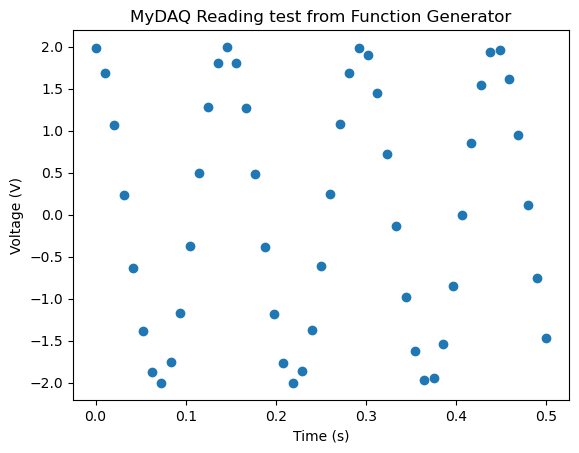

In [20]:
"""Exactly the same procedures hold for reading in data. Now that we have 
discusses writing to excessivly, you can do the reading part yourself"""

with dx.Task() as readTask:
    #Add the correct channel to readTask
    readTask.ai_channels.add_ai_voltage_chan('myDAQ1/ai0')
    
    #Again define the clock settings
    samps_per_chan = 50
    rate = 100
    
    readTask.timing.cfg_samp_clk_timing(rate,sample_mode = dx.constants.AcquisitionType.FINITE, samps_per_chan=samps_per_chan)
     
    #1 Channel 1 Sample read:
    data=readTask.read()
    
    #1 Channel N Samples read:
    data=readTask.read(number_of_samples_per_channel = samps_per_chan)

    x = np.linspace(0, samps_per_chan/rate, num=samps_per_chan-1)
    plt.figure(1)
    plt.scatter(x, data)
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)' )
    plt.title('MyDAQ Reading test from Function Generator')
    #plt.savefig(r'P:\PE1\Function1.pdf', format='pdf')
    plt.show()


<h4>1.2B: Reading from multiple inputs of the MyDAQ</h4>
You can also read from multiple inputs of the MyDAQ simultaneously.

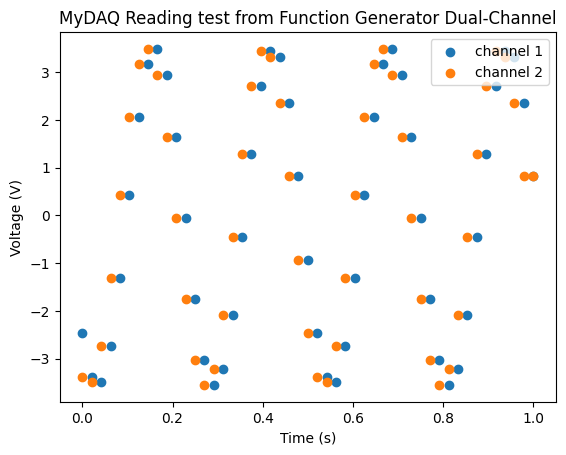

In [98]:
with dx.Task() as readTask:
    #Now we will add two channels to the readTask
    readTask.ai_channels.add_ai_voltage_chan('myDAQ1/ai0')
    readTask.ai_channels.add_ai_voltage_chan('myDAQ1/ai1')
    
    #Again define the clock settings
    samps_per_chan = 50
    rate = 50
    
    readTask.timing.cfg_samp_clk_timing(rate,sample_mode = dx.constants.AcquisitionType.FINITE, samps_per_chan=samps_per_chan)
     
    #2 Channel 1 Sample read:
    data=readTask.read()
    
    #2 Channel N Samples read:
    data=readTask.read(number_of_samples_per_channel = samps_per_chan)
    
    x = np.linspace(0, samps_per_chan/rate, num=samps_per_chan-1)

    plt.figure(1)
    plt.scatter(x, data[0], label='channel 1')
    plt.scatter(x, data[1], label='channel 2')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)' )
    plt.legend(loc=1)
    plt.title('MyDAQ Reading test from Function Generator Dual-Channel')
    plt.savefig(r'P:\PE1\Function2.pdf', format='pdf')
    plt.show()

<h3>1.3 Writing to & Reading from the MyDAQ</h3>

<h4>To do: Combine writing to and reading from the MyDAQ</h4>
Combine writing to and reading from the MyDAQ and prove that your program is working as it is supposed to.

<b> Tip: Use a BNC T-Adapter to read a signal on the MyDAQ and on the Oscilloscope simultaneously.</b>

In [ ]:
# To combine reading and writing you will need to put the two together.
with dx.Task('AOTask') as writeTask, dx.Task('AITask') as readTask:
    # Your code here:

<h3>Combining the MyDAQ with OOP </h3>
To avoid repetition in your code and to make reading and writing from and to the MyDAQ easier, you can create an object in which you define your functions.

(If you are not familiar with OOP anymore, you can do some exercises in the Jupyter Notebook on OOP.)

Create an object with which you can run the following code. Try to make some useful function which you think you will use in the future, for example a function to output a sine wave with a certain frequency and amplitude.

<b>Read the practical syllabus carefully before you start working on your MyDAQ class. Make sure that your code does everything which is stated in the syllabus.</b> 

In [5]:
class MyDAQ():
    def __init__(self, device_name='myDAQ1'):
        self.device_name = device_name
        self.write_task = None
        self.read_task = None

    def configure_write_task(self, rate=500, samps_per_chan=2500):
        self.write_task = dx.Task()
        self.write_task.ao_channels.add_ao_voltage_chan(f'{self.device_name}/ao0')
        self.write_task.timing.cfg_samp_clk_timing(
            rate,
            sample_mode = dx.constants.AcquisitionType.FINITE,
            samps_per_chan=samps_per_chan
        )
        self.samps_per_chan = samps_per_chan
        self.rate= rate
        
    def write(self, data):
        if self.write_task is None:
            raise Exception("Write task is not configured.")
        
        self.write_task.write(data, auto_start=True)
        time.sleep(self.samps_per_chan / self.rate + 0.001)
        self.write_task.stop()
    
    def configure_read_task(self, rate=100, samps_per_chan=50):
        """Configures the read task with the given parameters."""
        self.read_task = dx.Task()
        self.read_task.ai_channels.add_ai_voltage_chan(f'{self.device_name}/ai0')
        self.read_task.timing.cfg_samp_clk_timing(
            rate,
            sample_mode=dx.constants.AcquisitionType.FINITE,
            samps_per_chan=samps_per_chan
        )
        self.samps_per_chan = samps_per_chan
        self.rate = rate

    def read(self):
        """Reads data from the MyDAQ input."""
        if self.read_task is None:
            raise Exception("Read task is not configured.")
        
        data = self.read_task.read(number_of_samples_per_channel=self.samps_per_chan)
        return data


    def generate_sine_wave(self, frequency, amplitude, phase_shift, offset, duration):
        """Generates a sine wave with the specified parameters."""
        t = np.linspace(0, duration, int(self.rate * duration), endpoint=False)
        sine_wave = amplitude * np.sin(2 * np.pi * frequency * t + phase_shift) + offset
        return sine_wave
    
    
    def plot_data(self, data, output_path='output.pdf'):
        """Plots the data and saves the figure to a file."""
        x = np.linspace(0, self.samps_per_chan / self.rate, num=self.samps_per_chan - 1)
        plt.figure()
        plt.scatter(x, data)
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage (V)')
        plt.title('MyDAQ Reading test from Function Generator')
        plt.savefig(output_path, format='pdf')
        plt.show()

    def close(self):
        """Closes any open tasks."""
        if self.write_task is not None:
            self.write_task.close()
        if self.read_task is not None:
            self.read_task.close()

    def fft(self, data):
        """Performs FFT on the data and plots the frequency spectrum."""
        N = len(data)
        fft_values = fft(data)
        freqs = fftfreq(N, 1/self.rate)
        positive_freqs = freqs[:N//2]
        fft_magnitudes = np.abs(fft_values[:N//2])

        # Plot the frequency spectrum
        plt.figure()
        plt.plot(positive_freqs, fft_magnitudes)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.title('FFT Frequency Spectrum')
        plt.show()

        return positive_freqs, fft_magnitudes


In [23]:
"""
This is only an example of some functions that might be useful for you.
You can create/name them of course as you wish.
"""

# Example usage:
daq = MyDAQ()
# daq.configure_write_task(rate=500, samps_per_chan=2500)
stairs = [0.0, 0.0, 1.1, 2.2, 3.3, 4.4, 5.5, 6, 8, 9]
# daq.write_data(stairs)

# daq.configure_read_task(rate=100, samps_per_chan=50)
# data = daq.read_data()
data = stairs
daq.plot_data(data, output_path='function1.pdf')

daq.close()

AttributeError: 'MyDAQ' object has no attribute 'samps_per_chan'

In [6]:
# Example usage:
daq = MyDAQ()

# Configure for reading
daq.configure_read_task(rate=1000, samps_per_chan=1000)

# Simulate reading data from MyDAQ (replace this with actual read in practice)
signal_data = np.sin(2 * np.pi * 50 * daq.get_time_array())  # Example signal: 50 Hz sine wave

# Perform FFT on the data
daq.fft_analysis(signal_data)

daq.close()

Failed to get extended error info. DAQmxGetExtendedErrorInfo returned error code -200090.


DaqError: Failed to retrieve error description.

Status Code: -200090